In [13]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import OxfordIIITPet
from torch.utils.data import DataLoader, random_split
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from torchvision.transforms import InterpolationMode

class CustomOxfordPets(OxfordIIITPet):
    def __init__(self, *args, label_map=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.label_map = label_map

    def __getitem__(self, index):
        image, target = super().__getitem__(index)
        if self.label_map:
            target = self.label_map.get(target, target)
        return image, target

class LoadData:
    def __init__(self, binary=True):
        self.transform = self._get_transforms()
        self.classes = 2 if binary else 37
        self.label_map = self._get_label_map() if binary else None
        self.dataset_trainval = self._load_dataset(split='trainval')
        self.test_dataset = self._load_dataset(split='test')

    def _get_label_map(self):
        return {
            0: 0, 1: 1, 2: 1, 3: 1, 4: 1, 5: 0, 6: 0, 7: 0, 8: 1, 9: 0, 
            10: 1, 11: 0, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1,
            19: 1, 20: 0, 21: 1, 22: 1, 23: 0, 24: 1, 25: 1, 26: 0, 27: 0, 
            28: 1, 29: 1, 30: 1, 31: 1, 32: 0, 33: 0, 34: 1, 35: 1, 36: 1
        }

    def _get_transforms(self):
        return transforms.Compose([
            transforms.Resize(224, interpolation=InterpolationMode.BICUBIC),
            transforms.CenterCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def _load_dataset(self, split):
        return CustomOxfordPets(
            root='./data', transform=self.transform, download=True, 
            label_map=self.label_map, split=split
        )

    def data_loaders(self, batch_size, split_ratio, labeled_percent=1):
        train_size = int(split_ratio * len(self.dataset_trainval))
        val_size = len(self.dataset_trainval) - train_size
        train_dataset, val_dataset = random_split(self.dataset_trainval, [train_size, val_size])

        loaders = {
            'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True),
            'val': DataLoader(val_dataset, batch_size=batch_size, shuffle=True),
            'test': DataLoader(self.test_dataset, batch_size=batch_size, shuffle=False)
        }

        if labeled_percent < 1:
            pseudo_train_size = int(labeled_percent * train_size)
            train_pseudo, guess_pseudo = random_split(train_dataset, [pseudo_train_size, train_size - pseudo_train_size])
            loaders['train_pseudo'] = DataLoader(train_pseudo, batch_size=batch_size, shuffle=True)
            loaders['guess'] = DataLoader(guess_pseudo, batch_size=batch_size, shuffle=True)

        return loaders

class Train:
    def __init__(self, lr, bs, epochs, split_ratio, binary, model_path=None, labeled_percent=1):
        self.lr = lr
        self.epochs = epochs
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.data = LoadData(binary=binary)
        self.loaders = self.data.data_loaders(bs, split_ratio, labeled_percent)
        self.model = self._initialize_model(model_path)
        self.loss_func = nn.BCEWithLogitsLoss()
        self.optimizer = optim.Adam(self.model.fc.parameters(), lr=lr)
        self.scheduler = lr_scheduler.StepLR(self.optimizer, step_size=5, gamma=0.1)

    def _initialize_model(self, model_path):
        model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

        for param in model.parameters():
            param.requires_grad = False
        for param in model.layer4.parameters():
            param.requires_grad = True

        model.fc = nn.Linear(model.fc.in_features, 1)
        if model_path:
            model.load_state_dict(torch.load(model_path))
        return model.to(self.device)

    def train(self):
        self.model.train()
        self.training_losses = []  # 初始化训练损失列表
        self.validation_losses = []  # 初始化验证损失列表

        for epoch in range(self.epochs):
            train_loss = self._run_epoch(self.loaders['train'], training=True)
            val_loss = self._run_epoch(self.loaders['val'], training=False)
            
            self.training_losses.append(train_loss)  # 记录每个 epoch 的训练损失
            self.validation_losses.append(val_loss)  # 记录每个 epoch 的验证损失
            
            self.scheduler.step()
            print(f'Epoch {epoch + 1}/{self.epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

        self._plot_loss(self.training_losses, self.validation_losses)
        
        accuracy = self._evaluate(self.loaders['test'])
        print(f'Final Test Accuracy: {accuracy:.4f}')
        return accuracy

    def _run_epoch(self, loader, training=True):
        if training:
            self.model.train()
        else:
            self.model.eval()

        running_loss = 0.0
        with torch.set_grad_enabled(training):
            for images, labels in loader:
                images, labels = images.to(self.device), labels.float().to(self.device)
                outputs = self.model(images)
                loss = self.loss_func(outputs, labels.unsqueeze(1))
                if training:
                    self.optimizer.zero_grad()
                    loss.backward()
                    self.optimizer.step()
                running_loss += loss.item() * images.size(0)

        return running_loss / len(loader.dataset)

    def _evaluate(self, loader):
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in loader:
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = torch.sigmoid(self.model(images))
                preds = (outputs > 0.5).float()
                correct += (preds.cpu() == labels.cpu().unsqueeze(1)).sum().item()
                total += labels.size(0)

        accuracy = correct / total
        print(f'Accuracy: {accuracy:.4f}')
        return accuracy

    def _plot_loss(self, training_losses, validation_losses):
        epochs = np.arange(1, self.epochs + 1)
        plt.figure()
        plt.plot(epochs, training_losses, 'r', label='Training Loss')
        plt.plot(epochs, validation_losses, 'b', label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()


Batch size is 8 and learning rate is 0.0005
Epoch 1/16, Training Loss: 0.2648, Validation Loss: 0.0844
Epoch 2/16, Training Loss: 0.1628, Validation Loss: 0.0576
Epoch 3/16, Training Loss: 0.1223, Validation Loss: 0.0499
Epoch 4/16, Training Loss: 0.1183, Validation Loss: 0.0456
Epoch 5/16, Training Loss: 0.1068, Validation Loss: 0.0454
Epoch 6/16, Training Loss: 0.1018, Validation Loss: 0.0401
Epoch 7/16, Training Loss: 0.1006, Validation Loss: 0.0370
Epoch 8/16, Training Loss: 0.0996, Validation Loss: 0.0337
Epoch 9/16, Training Loss: 0.0819, Validation Loss: 0.0485
Epoch 10/16, Training Loss: 0.0951, Validation Loss: 0.0430
Epoch 11/16, Training Loss: 0.0945, Validation Loss: 0.0450
Epoch 12/16, Training Loss: 0.1073, Validation Loss: 0.0381
Epoch 13/16, Training Loss: 0.0919, Validation Loss: 0.0480
Epoch 14/16, Training Loss: 0.0939, Validation Loss: 0.0422
Epoch 15/16, Training Loss: 0.0964, Validation Loss: 0.0419
Epoch 16/16, Training Loss: 0.1115, Validation Loss: 0.0397


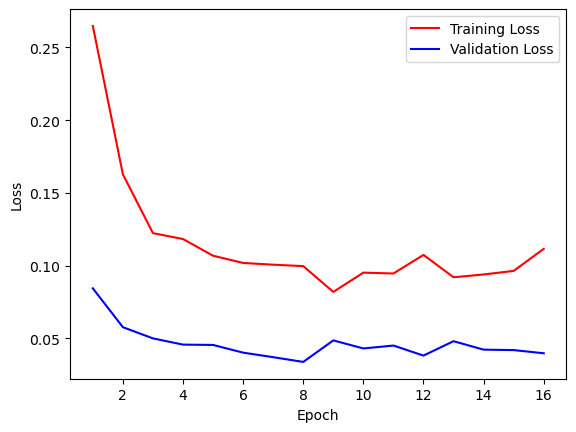

Accuracy: 0.9932
Final Test Accuracy: 0.9932


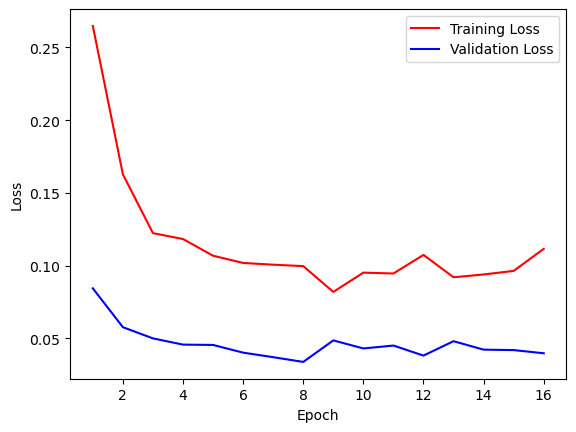

In [14]:
# 首先，初始化数据加载器对象
load_data = LoadData(binary=True)

# 然后，初始化训练对象，传入必要的参数
train = Train(lr=0.0005, bs=8, epochs=16, split_ratio=0.8, binary=True, model_path=None, labeled_percent=1)

# 打印当前的 batch size 和学习率
print(f"Batch size is {8} and learning rate is {0.0005}")

# 训练模型并输出训练准确率
train.train()

# 绘制损失曲线
train._plot_loss(train.training_losses, train.validation_losses)

Running configuration: ['fc']
Epoch 1: Train Loss = 1.5442, Train Accuracy = 0.6461, Validation Loss = 0.5467, Validation Accuracy = 0.8872
Epoch 2: Train Loss = 0.4866, Train Accuracy = 0.8815, Validation Loss = 0.3480, Validation Accuracy = 0.9117
Epoch 3: Train Loss = 0.3343, Train Accuracy = 0.9137, Validation Loss = 0.3015, Validation Accuracy = 0.9062
Epoch 4: Train Loss = 0.2811, Train Accuracy = 0.9236, Validation Loss = 0.2945, Validation Accuracy = 0.9035
Epoch 5: Train Loss = 0.2444, Train Accuracy = 0.9290, Validation Loss = 0.2772, Validation Accuracy = 0.9212
Epoch 6: Train Loss = 0.1981, Train Accuracy = 0.9474, Validation Loss = 0.2825, Validation Accuracy = 0.9062
Epoch 7: Train Loss = 0.1874, Train Accuracy = 0.9487, Validation Loss = 0.2573, Validation Accuracy = 0.9198
Epoch 8: Train Loss = 0.1553, Train Accuracy = 0.9558, Validation Loss = 0.2324, Validation Accuracy = 0.9389
Epoch 9: Train Loss = 0.1527, Train Accuracy = 0.9562, Validation Loss = 0.2647, Validatio

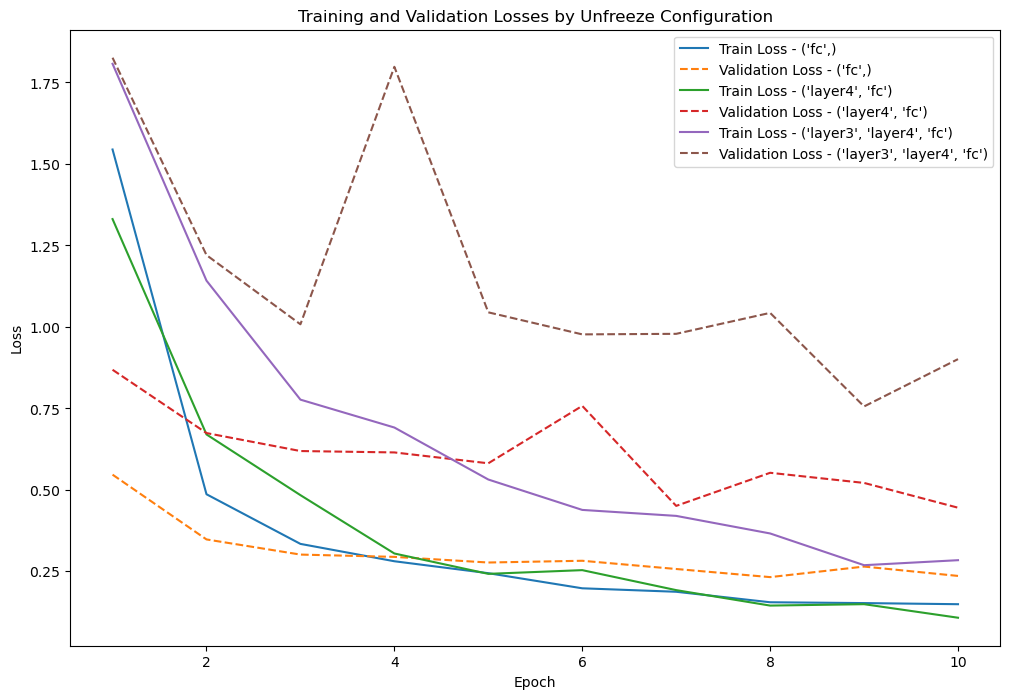

In [5]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import OxfordIIITPet
from torch.utils.data import DataLoader, random_split
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from torchvision.transforms import InterpolationMode

class CustomOxfordPets(OxfordIIITPet):
    def __init__(self, *args, label_map=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.label_map = label_map

    def __getitem__(self, index):
        image, target = super().__getitem__(index)
        if self.label_map:
            target = self.label_map.get(target, target)
        return image, target

class LoadData:
    def __init__(self, binary=True):
        self.transform = self._get_transforms()
        self.classes = 2 if binary else 37
        self.label_map = self._get_label_map() if binary else None
        self.dataset_trainval = self._load_dataset(split='trainval')
        self.test_dataset = self._load_dataset(split='test')

    def _get_label_map(self):
        return {
            0: 0, 1: 1, 2: 1, 3: 1, 4: 1, 5: 0, 6: 0, 7: 0, 8: 1, 9: 0, 
            10: 1, 11: 0, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1,
            19: 1, 20: 0, 21: 1, 22: 1, 23: 0, 24: 1, 25: 1, 26: 0, 27: 0, 
            28: 1, 29: 1, 30: 1, 31: 1, 32: 0, 33: 0, 34: 1, 35: 1, 36: 1
        }

    def _get_transforms(self):
        return transforms.Compose([
            transforms.Resize(224, interpolation=InterpolationMode.BICUBIC),
            transforms.CenterCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def _load_dataset(self, split):
        return CustomOxfordPets(
            root='./data', transform=self.transform, download=True, 
            label_map=self.label_map, split=split
        )

    def data_loaders(self, batch_size, split_ratio, labeled_percent=1):
        train_size = int(split_ratio * len(self.dataset_trainval))
        val_size = len(self.dataset_trainval) - train_size
        train_dataset, val_dataset = random_split(self.dataset_trainval, [train_size, val_size])

        loaders = {
            'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True),
            'val': DataLoader(val_dataset, batch_size=batch_size, shuffle=True),
            'test': DataLoader(self.test_dataset, batch_size=batch_size, shuffle=False)
        }

        if labeled_percent < 1:
            pseudo_train_size = int(labeled_percent * train_size)
            train_pseudo, guess_pseudo = random_split(train_dataset, [pseudo_train_size, train_size - pseudo_train_size])
            loaders['train_pseudo'] = DataLoader(train_pseudo, batch_size=batch_size, shuffle=True)
            loaders['guess'] = DataLoader(guess_pseudo, batch_size=batch_size, shuffle=True)

        return loaders

class Train:
    def __init__(self, lr, bs, epochs, split_ratio, binary, model_path=None, labeled_percent=1, unfreeze_from=None):
        self.lr = lr
        self.epochs = epochs
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.data = LoadData(binary=False)  # 此处 binary 应为 False，因为是多类分类
        self.loaders = self.data.data_loaders(bs, split_ratio, labeled_percent)
        self.model = self._initialize_model(model_path, num_classes=37, unfreeze_from=unfreeze_from)
        self.loss_func = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(filter(lambda p: p.requires_grad, self.model.parameters()), lr=lr)
        self.scheduler = lr_scheduler.StepLR(self.optimizer, step_size=5, gamma=0.1)

    def _initialize_model(self, model_path, num_classes, unfreeze_from):
        model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        for param in model.parameters():
            param.requires_grad = False
        
        # Unfreeze the specified layers
        layers_to_unfreeze = ['layer3', 'layer4', 'fc']
        for layer_name in layers_to_unfreeze:
            if layer_name in unfreeze_from:
                for param in getattr(model, layer_name).parameters():
                    param.requires_grad = True

        model.fc = nn.Linear(model.fc.in_features, num_classes)
        if model_path:
            model.load_state_dict(torch.load(model_path))
        return model.to(self.device)

    def train(self):
        self.model.train()  # Ensure model is in training mode
        train_loss = 0.0
        correct, total = 0, 0
        for images, labels in self.loaders['train']:
            images, labels = images.to(self.device), labels.to(self.device)
            self.optimizer.zero_grad()
            outputs = self.model(images)
            loss = self.loss_func(outputs, labels)
            loss.backward()
            self.optimizer.step()
            train_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        train_loss /= len(self.loaders['train'].dataset)
        accuracy = correct / total
        return train_loss, accuracy

    def validate(self):
        self.model.eval()  # Ensure model is in evaluation mode
        val_loss = 0.0
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in self.loaders['val']:
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self.model(images)
                loss = self.loss_func(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_loss /= len(self.loaders['val'].dataset)
        accuracy = correct / total
        return val_loss, accuracy

def run_experiment(freeze_configs):
    results = {}
    for config in freeze_configs:
        config_tuple = tuple(config)  # Convert list to tuple for dictionary key
        print(f"Running configuration: {config}")
        trainer = Train(lr=0.001, bs=32, epochs=10, split_ratio=0.8, binary=False, model_path=None, labeled_percent=1, unfreeze_from=config)
        for epoch in range(trainer.epochs):
            train_loss, train_accuracy = trainer.train()
            val_loss, val_accuracy = trainer.validate()
            print(f'Epoch {epoch + 1}: Train Loss = {train_loss:.4f}, Train Accuracy = {train_accuracy:.4f}, Validation Loss = {val_loss:.4f}, Validation Accuracy = {val_accuracy:.4f}')
            if config_tuple not in results:
                results[config_tuple] = {'train_loss': [], 'train_accuracy': [], 'val_loss': [], 'val_accuracy': []}
            results[config_tuple]['train_loss'].append(train_loss)
            results[config_tuple]['train_accuracy'].append(train_accuracy)
            results[config_tuple]['val_loss'].append(val_loss)
            results[config_tuple]['val_accuracy'].append(val_accuracy)
    return results

def plot_results(results):
    plt.figure(figsize=(12, 8))
    for config, metrics in results.items():
        epochs = range(1, len(metrics['train_loss']) + 1)
        plt.plot(epochs, metrics['train_loss'], label=f'Train Loss - {config}')
        plt.plot(epochs, metrics['val_loss'], label=f'Validation Loss - {config}', linestyle='--')
    plt.title('Training and Validation Losses by Unfreeze Configuration')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

freeze_configs = [
    ['fc'],  # Only final layer
    ['layer4', 'fc'],  # Last block and final layer
    ['layer3', 'layer4', 'fc']  # Last two blocks and final layer
]

results = run_experiment(freeze_configs)
plot_results(results)


In [3]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import OxfordIIITPet
from torch.utils.data import DataLoader, random_split
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from torchvision.transforms import InterpolationMode

class CustomOxfordPets(OxfordIIITPet):
    def __init__(self, *args, label_map=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.label_map = label_map

    def __getitem__(self, index):
        image, target = super().__getitem__(index)
        if self.label_map:
            target = self.label_map.get(target, target)
        return image, target

class LoadData:
    def __init__(self, binary=True):
        self.transform = self._get_transforms()
        self.classes = 2 if binary else 37
        self.label_map = self._get_label_map() if binary else None
        self.dataset_trainval = self._load_dataset(split='trainval')
        self.test_dataset = self._load_dataset(split='test')

    def _get_label_map(self):
        return {
            0: 0, 1: 1, 2: 1, 3: 1, 4: 1, 5: 0, 6: 0, 7: 0, 8: 1, 9: 0, 
            10: 1, 11: 0, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1,
            19: 1, 20: 0, 21: 1, 22: 1, 23: 0, 24: 1, 25: 1, 26: 0, 27: 0, 
            28: 1, 29: 1, 30: 1, 31: 1, 32: 0, 33: 0, 34: 1, 35: 1, 36: 1
        }

    def _get_transforms(self):
        return transforms.Compose([
            transforms.Resize(224, interpolation=InterpolationMode.BICUBIC),
            transforms.CenterCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def _load_dataset(self, split):
        return CustomOxfordPets(
            root='./data', transform=self.transform, download=True, 
            label_map=self.label_map, split=split
        )

    def data_loaders(self, batch_size, split_ratio, labeled_percent=1):
        train_size = int(split_ratio * len(self.dataset_trainval))
        val_size = len(self.dataset_trainval) - train_size
        train_dataset, val_dataset = random_split(self.dataset_trainval, [train_size, val_size])

        loaders = {
            'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True),
            'val': DataLoader(val_dataset, batch_size=batch_size, shuffle=True),
            'test': DataLoader(self.test_dataset, batch_size=batch_size, shuffle=False)
        }

        if labeled_percent < 1:
            pseudo_train_size = int(labeled_percent * train_size)
            train_pseudo, guess_pseudo = random_split(train_dataset, [pseudo_train_size, train_size - pseudo_train_size])
            loaders['train_pseudo'] = DataLoader(train_pseudo, batch_size=batch_size, shuffle=True)
            loaders['guess'] = DataLoader(guess_pseudo, batch_size=batch_size, shuffle=True)

        return loaders

In [4]:
from torchvision.models import resnet50, ResNet50_Weights
class Train:
    def __init__(self, layer_lr, bs, epochs, split_ratio, binary, model_path=None, labeled_percent=1, unfreeze_layers=None):
        self.epochs = epochs
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.data = LoadData(binary=False)
        self.loaders = self.data.data_loaders(bs, split_ratio, labeled_percent)
        self.model = self._initialize_model(model_path, num_classes=37, unfreeze_layers=unfreeze_layers)
        self.loss_func = nn.CrossEntropyLoss()
        self.optimizer = self._create_optimizer(layer_lr)
        self.scheduler = lr_scheduler.StepLR(self.optimizer, step_size=5, gamma=0.1)
        self.training_losses = []
        self.validation_losses = []
        self.validation_accuracies = []

    def train(self):
        for epoch in range(self.epochs):
            self.model.train()
            train_loss = 0
            for images, labels in self.loaders['train']:
                images = images.to(self.device)
                labels = labels.to(self.device)
                self.optimizer.zero_grad()
                outputs = self.model(images)
                loss = self.loss_func(outputs, labels)
                loss.backward()
                self.optimizer.step()
                train_loss += loss.item() * images.size(0)
            train_loss /= len(self.loaders['train'].dataset)

            val_loss, val_accuracy = self.validate()
            self.training_losses.append(train_loss)
            self.validation_losses.append(val_loss)
            self.validation_accuracies.append(val_accuracy)
            self.scheduler.step()

            # Print losses and accuracy for each epoch
            print(f'Epoch {epoch+1}/{self.epochs}: Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4%}')

    def validate(self):
        self.model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in self.loaders['val']:
                images = images.to(self.device)
                labels = labels.to(self.device)
                outputs = self.model(images)
                loss = self.loss_func(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_loss /= len(self.loaders['val'].dataset)
        val_accuracy = correct / total
        return val_loss, val_accuracy

    def _initialize_model(self, model_path, num_classes, unfreeze_layers):
        model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1 if not model_path else None)
        for param in model.parameters():
            param.requires_grad = False
        
        for layer_name in unfreeze_layers:
            for param in getattr(model, layer_name).parameters():
                param.requires_grad = True

        model.fc = nn.Linear(model.fc.in_features, num_classes)
        if model_path:
            model.load_state_dict(torch.load(model_path))
        return model.to(self.device)

    def _create_optimizer(self, layer_lr):
        param_groups = []
        for layer_name, lr in layer_lr.items():
            params = [param for param in getattr(self.model, layer_name).parameters() if param.requires_grad]
            param_groups.append({'params': params, 'lr': lr})
        return optim.Adam(param_groups)

    


In [5]:
def run_experiments(layer_configs, layer_lrs):
    results = {}
    for layers in layer_configs:
        for lr in layer_lrs:
            config_key = f"Layers: {layers}, LR: {lr}"
            print(f"Running configuration: {config_key}")
            layer_lr = {layer: lr for layer in layers}
            trainer = Train(layer_lr, bs=32, epochs=10, split_ratio=0.8, binary=False, unfreeze_layers=layers)
            trainer.train()
            results[config_key] = {
                'train_loss': trainer.training_losses,
                'val_loss': trainer.validation_losses,
                'val_accuracy': trainer.validation_accuracies
            }
    return results

def plot_results(results):
    fig, axs = plt.subplots(2, 1, figsize=(12, 16))
    for config, metrics in results.items():
        epochs = range(1, len(metrics['train_loss']) + 1)
        axs[0].plot(epochs, metrics['train_loss'], label=f"{config} - Train")
        axs[0].plot(epochs, metrics['val_loss'], label=f"{config} - Validation", linestyle='--')
        axs[1].plot(epochs, metrics['val_accuracy'], label=f"{config} - Val Accuracy")
    
    axs[0].set_title('Training and Validation Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend(loc='upper right')

    axs[1].set_title('Validation Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend(loc='upper right')

    plt.tight_layout()
    plt.show()


Running configuration: Layers: ['fc'], LR: 0.001
Epoch 1/10: Train Loss: 1.5064, Validation Loss: 0.5399, Validation Accuracy: 87.7717%
Epoch 2/10: Train Loss: 0.4517, Validation Loss: 0.4002, Validation Accuracy: 88.8587%
Epoch 3/10: Train Loss: 0.3476, Validation Loss: 0.3257, Validation Accuracy: 91.3043%
Epoch 4/10: Train Loss: 0.2685, Validation Loss: 0.3204, Validation Accuracy: 90.3533%
Epoch 5/10: Train Loss: 0.2437, Validation Loss: 0.3223, Validation Accuracy: 89.6739%
Epoch 6/10: Train Loss: 0.1897, Validation Loss: 0.2452, Validation Accuracy: 92.3913%
Epoch 7/10: Train Loss: 0.1620, Validation Loss: 0.2502, Validation Accuracy: 91.5761%
Epoch 8/10: Train Loss: 0.1700, Validation Loss: 0.2503, Validation Accuracy: 92.7989%
Epoch 9/10: Train Loss: 0.1626, Validation Loss: 0.2494, Validation Accuracy: 92.2554%
Epoch 10/10: Train Loss: 0.1571, Validation Loss: 0.2499, Validation Accuracy: 92.9348%
Running configuration: Layers: ['fc'], LR: 0.0001
Epoch 1/10: Train Loss: 3.1764

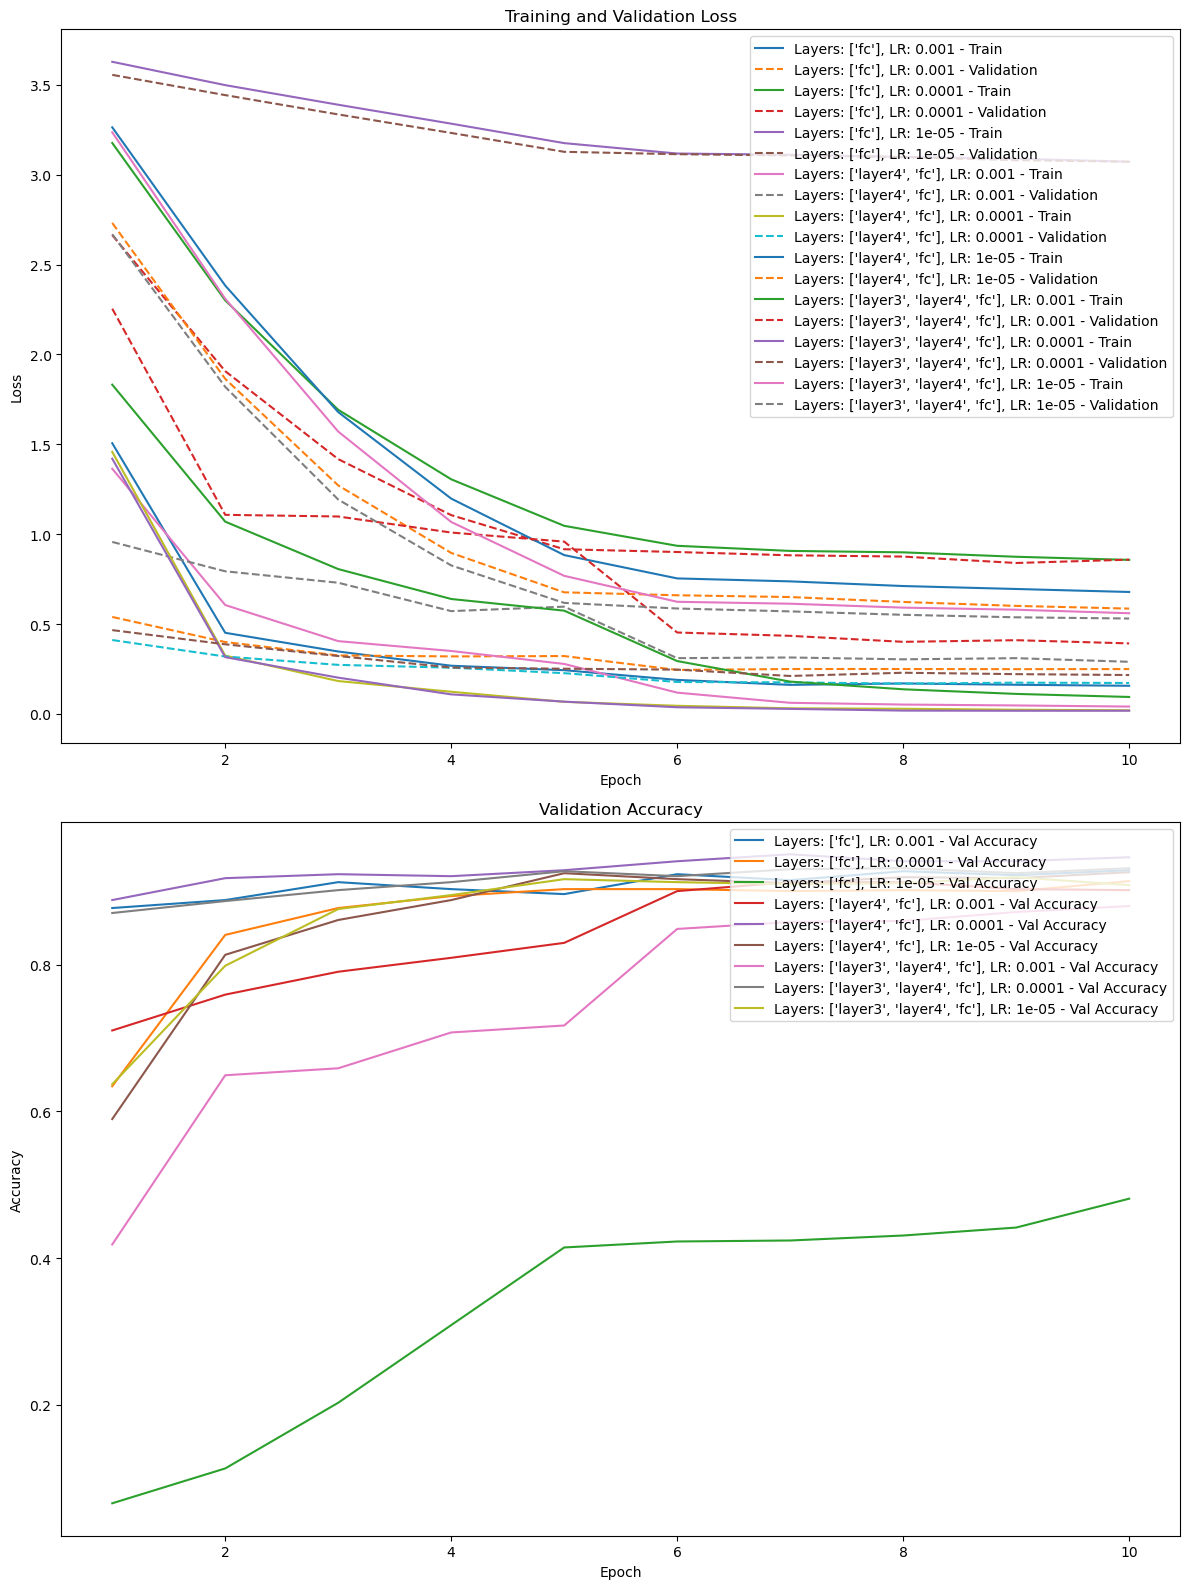

In [6]:
layer_configs = [
    ['fc'],
    ['layer4', 'fc'],
    ['layer3', 'layer4', 'fc']
]
learning_rates = [1e-3, 1e-4, 1e-5]

results = run_experiments(layer_configs, learning_rates)
plot_results(results)


In [7]:
import json

def save_results_json(results, filename):
    with open(filename, 'w') as f:
        json.dump(results, f)

# 注意：确保 `results` 中的数据可以被直接序列化为JSON，否则你可能需要先处理数据
save_results_json(results, 'experiment_results.json')


In [8]:
print(results)

{"Layers: ['fc'], LR: 0.001": {'train_loss': [1.5063864442965258, 0.4516604644772799, 0.34762986214912456, 0.26849165777473344, 0.24367177980425564, 0.18972820918197217, 0.16203266730451066, 0.1700240128228198, 0.16263970226535332, 0.1570532406153886], 'val_loss': [0.5399155837038289, 0.40023380323596625, 0.32573825315288873, 0.32037484192329907, 0.32231642840349156, 0.24519347237504047, 0.2502097053372342, 0.25027694617924484, 0.24942966809739237, 0.24994497422290884], 'val_accuracy': [0.8777173913043478, 0.8885869565217391, 0.9130434782608695, 0.9035326086956522, 0.8967391304347826, 0.9239130434782609, 0.9157608695652174, 0.9279891304347826, 0.9225543478260869, 0.9293478260869565]}, "Layers: ['fc'], LR: 0.0001": {'train_loss': [3.1764479331348254, 2.3008796883666, 1.6922655818255052, 1.3055958514628203, 1.0467815710150676, 0.9356168061494827, 0.9072194157735162, 0.8993049471274667, 0.8746333504500596, 0.8572575683179109], 'val_loss': [2.66397792360057, 1.9070831485416577, 1.417755308

In [15]:
def select_best_accuracy_per_lr(results):
    best_per_lr = {}
    for key, metrics in results.items():
        _, lr = key.split(', LR: ')
        # 找到最高准确率及其索引
        max_index = max(range(len(metrics['val_accuracy'])), key=lambda index: metrics['val_accuracy'][index])
        max_accuracy = metrics['val_accuracy'][max_index]
        if lr not in best_per_lr or max_accuracy > best_per_lr[lr][1]:
            best_per_lr[lr] = (key, max_accuracy, metrics['val_loss'][max_index])
    return {config[0]: results[config[0]] for _, config in best_per_lr.items()}


In [18]:
import matplotlib.pyplot as plt

def plot_best_accuracy(best_configs):
    plt.figure(figsize=(10, 6))
    for config, data in best_configs.items():
        epochs = range(1, len(data['val_accuracy']) + 1)
        plt.plot(epochs, data['val_accuracy'], label=f'{config}', marker='o')
    plt.title('Best Validation Accuracy per Learning Rate')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_best_loss(best_configs):
    plt.figure(figsize=(10, 6))
    for config, data in best_configs.items():
        epochs = range(1, len(data['val_loss']) + 1)
        plt.plot(epochs, data['val_loss'], label=f'{config}', marker='x')
    plt.title('Validation Loss for Best Accuracy per Learning Rate')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


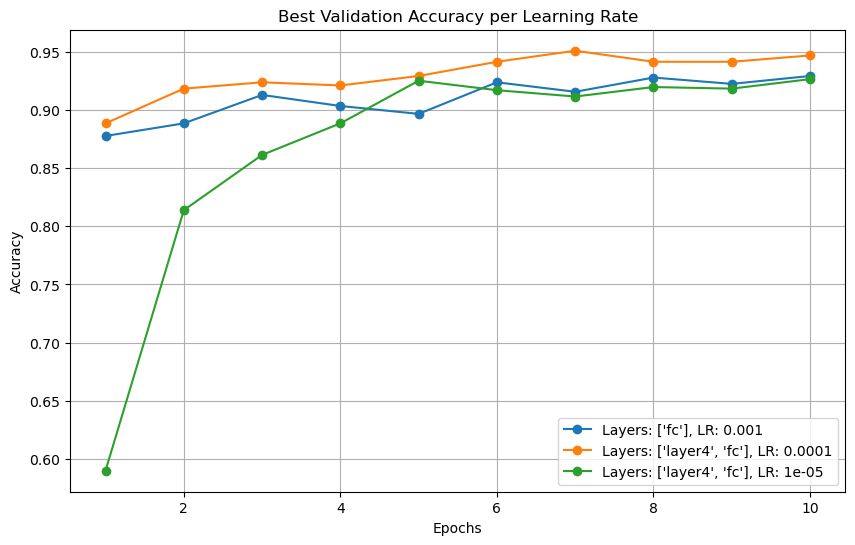

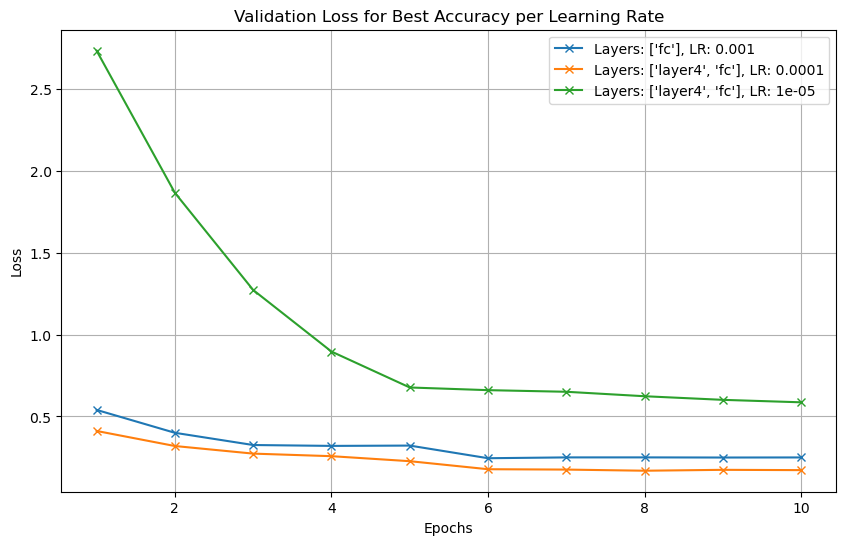

In [19]:
# 假设 results 是你的训练结果
best_configs = select_best_accuracy_per_lr(results)

# 调用绘图函数
plot_best_accuracy(best_configs)
plot_best_loss(best_configs)
